# Stinger Formulation

In [36]:
scaling_cols = ['launch_speed','launch_angle']
cols = ['name','launch_speed','launch_angle','batter', 'events', 'hc_x','hc_y','relative_spray','description']
desc_cols = ['launch_speed','launch_angle', 'cluster']
spray_cols = ['launch_speed','launch_angle','relative_spray']

# Preprocessing and scaling

def statcast_spray(statcast_df):
    # Returns the spray_angle which is calculated from the x and y hitting coordinate features in statcast_df
    
    statcast_df['spray_angle'] = np.arctan((statcast_df['hc_x']-125.42)/(198.27-statcast_df['hc_y']))*(180/math.pi)
    statcast_df['relative_spray'] = np.where(
        statcast_df['stand']=='L',
        statcast_df['spray_angle']*-1,
        statcast_df['spray_angle']
    )
    return statcast_df

def statcast_hit_in_play(df):
    # Returns a filtered version of a Statcast DataFrame with only batted balls
    return df[(df['description'] == 'hit_into_play')|
        (df['description'] == 'hit_into_play_no_out') |
        (df['description'] == 'hit_into_play_score')
        ]

def extract_batter_names(df):
    # Extracts the first two words of the description field, format of that field puts 
    # is a string that starts with the name of the batter and what occured
    # i.e., "Vladimir Guerrero hits a home run 450 feet" 
#    cleaned_des = df['des'].str.replace(r'^(Umpire reviewed|Play reviewed).*?:\s*', '', regex=True, case=False)
    df['name'] = df['des'].str.split().str[0:2].str.join(' ')
    return df

def statcast_scale_bbes(bbes):
    # StandardScaler() scaling
    # input: bbes - a DataFrame with Statcast data, for our purposes those will be bbes
    # output: returns the scaled bbes array.
    df = bbes[scaling_cols].dropna(inplace=False)
    scaler = StandardScaler()
    return scaler.fit_transform(df)

# Clustering helpers

def silhouette_and_elbow(scaled_df, k_range):
    # Returns a graph and dictionary of the silhouette scores. More efficient to do together.
    silhouettes = {}
    inertias = []

    for k in k_range:
        km = KMeans(n_clusters=k, n_init = 10, random_state=RANDOM_STATE).fit(scaled_df)
        silhouettes[str(k)] = silhouette_score(scaled_df,km.labels_)
        inertias.append(km.inertia_)
    plt.figure(figsize=(10,6))
    plt.plot(k_range,inertias,marker='o', linestyle='--')
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('Inertia')
    plt.title('Elbow Plot')
    plt.show
    
    print(silhouettes)
    
    return silhouettes

def pick_highest_EV_cluster(bbes):
    # Helper function which returns the index of the cluster of a bbe DataFrame
    # with the greatest launch_speed value. This is to identify the line-drive 
    # cluster of balls.
    
    summary = bbes[desc_cols].groupby('cluster').mean()
    return summary['launch_speed'].idxmax()

def get_stinger_clusters(line_drives):
    # Returns integers corresponding to the index of clusters of a cluster-labelled
    # line drives DataFrame. Clusters contain potential stingers.
    
    summary = line_drives[desc_cols].groupby('cluster').mean()
    
    barrels = [summary['launch_angle'].idxmax()]
    non_barrels = summary.iloc[~summary.index.isin(barrels)]
    
    stinger1 = [non_barrels['launch_angle'].idxmax()]
    temp = non_barrels.iloc[~non_barrels.index.isin(stinger1)]
    stinger2 = [temp['launch_angle'].idxmax()]
    
    return stinger1[0], stinger2[0]

def filter_stingers(pot_stingers):
    # Filters out stingers (well-hit line drives) from a potential stingers dataframe
    
    stingers = pot_stingers[((pot_stingers['launch_angle'] <= 18) & (pot_stingers['launch_angle'] >= 5) & (pot_stingers['launch_speed'] >= 95))|
        ((pot_stingers['launch_angle'] <= 20) & (pot_stingers['launch_angle'] >= 10) & (pot_stingers['launch_speed'] >= 90))|
        ((pot_stingers['launch_angle'] <= 20) & (pot_stingers['launch_angle'] >= 12.5) & (pot_stingers['launch_speed'] >=85))|
        ((pot_stingers['launch_angle'] <= 20) & (pot_stingers['launch_angle'] >= 15) & (pot_stingers['launch_speed'] >=80))
        ]
    return stingers

def filter_gappers(stingers):
    # Filters gappers from stingers.
    gappers = stingers[((stingers['relative_spray'].abs() <= 25) & (stingers['relative_spray'].abs() >= 10)) |
                        ((stingers['relative_spray'].abs() >= 37.5) & (stingers['relative_spray'].abs() <= 45))
                        ]
    return gappers    

def get_counts(data):
    counts = {'singles': len(data[data['events']=='single']),
              'doubles': len(data[data['events']=='double']),
              'triples': len(data[data['events']=='triple']),
              'home runs': len(data[data['events']=='home_run']),
              'field outs': len(data[data['events']=='field_out']),
              'gidps': len(data[data['events'] == 'grounded_into_double_play']),
              'force_outs': len(data[data['events']=='force_out']),
              'dps': len(data[data['events']=='double_play']),
              'fcs': (len(data[data['events']=='fielders_choice'])+len(data[data['events']=='fielders_choice_out'])),
              'k': len(data[data['events']=='strikeout']),
              'bb': len(data[data['events'] == 'walk']),
              'ibb': len(data[data['events'] == 'intent_walk']),
              'hbp': len(data[data['events'] == 'hit_by_pitch']),
              'e': len(data[data['events'] == 'error']),
             }
    
    return counts

def create_stats(counts):
    atbats = sum(counts.values())

    stats = {'BA': (counts['singles']+counts['doubles']+counts['triples']+counts['home runs'])/atbats,
            'SLG': (counts['singles']+2*counts['doubles']+3*counts['triples']+4*counts['home runs'])/atbats
             
            }
    return stats


def get_stingers(data):
    # Main function, takes in Statcast data and returns filtered DataFrames with 
    # stingers and gappers. 
    
    # statcast_spray and extract_batter helper functions create attributes 'name',
    # 'spray_angle' and 'relative_spray'
    data = statcast_spray(data)
    data = extract_batter_names(data)
    df = data[cols]

    # helper functions filter the statcast data by whether or not the record represented
    # a batted-ball-event, and create a scaled version for clustering
    bbes = statcast_hit_in_play(df).dropna(inplace=False)
    bbes_scaled = statcast_scale_bbes(bbes[scaling_cols])

    # creates a k-means model with 3 clusters, then use fit_predict to get 
    # cluster labels and create 'cluster' attribute
    km = KMeans(n_clusters=3,n_init=10,random_state=RANDOM_STATE)
    bbes['cluster'] = km.fit_predict(bbes_scaled)
    
    # get integer corresponding to the cluster with the highest launch_speed (EV)
    cluster_idx = pick_highest_EV_cluster(bbes)

    # use the cluster index to filter all batted-ball-events to just line-drives
    line_drives = bbes[(bbes['cluster']==cluster_idx)].drop('cluster',axis=1,inplace=False)
    line_drives_scaled = statcast_scale_bbes(line_drives[scaling_cols])
    
    # create a 4 cluster kmeans model to get cluster labels for the line-drive clusters
    km_drives = KMeans(n_clusters=4,n_init=10,random_state=RANDOM_STATE)
    line_drives['cluster'] = km_drives.fit_predict(line_drives_scaled)

    # helper function returns integers corresponding to the cluster labels of the 
    # potential stinger clusters (high EV, mid-positive LA)
    stinger1, stinger2 = get_stinger_clusters(line_drives)
    pot_stingers = line_drives[(line_drives['cluster'] == stinger1) | (line_drives['cluster'] == stinger2)]

    # helper functions to filter potential stingers to stingers, and stingers to gappers
    stingers = filter_stingers(pot_stingers)
    gappers = filter_gappers(stingers)
    return (stingers, gappers)


In [2]:
from pybaseball import statcast, statcast_batter
import numpy as np
import math
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import KFold, cross_val_score
from pybaseball import playerid_reverse_lookup
import warnings
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split


RANDOM_STATE = 27 # For Vladdy Jr., my favourite player


In [3]:
warnings.filterwarnings('ignore')
data = statcast(start_dt = '2024-03-27', end_dt = '2024-09-29')
warnings.resetwarnings()

This is a large query, it may take a moment to complete


100%|████████████████████████████████████████████████████████████████████████████████| 187/187 [01:28<00:00,  2.11it/s]


In [4]:
df = data.copy()

In [13]:
stingers, gappers = get_stingers(df)

{'2': 0.4139971761743705, '3': 0.40246311560718134, '4': 0.35397796122608743, '5': 0.3551918618965388, '6': 0.3367573592769538, '7': 0.3468409593522455}


{'2': 0.4139971761743705,
 '3': 0.40246311560718134,
 '4': 0.35397796122608743,
 '5': 0.3551918618965388,
 '6': 0.3367573592769538,
 '7': 0.3468409593522455}

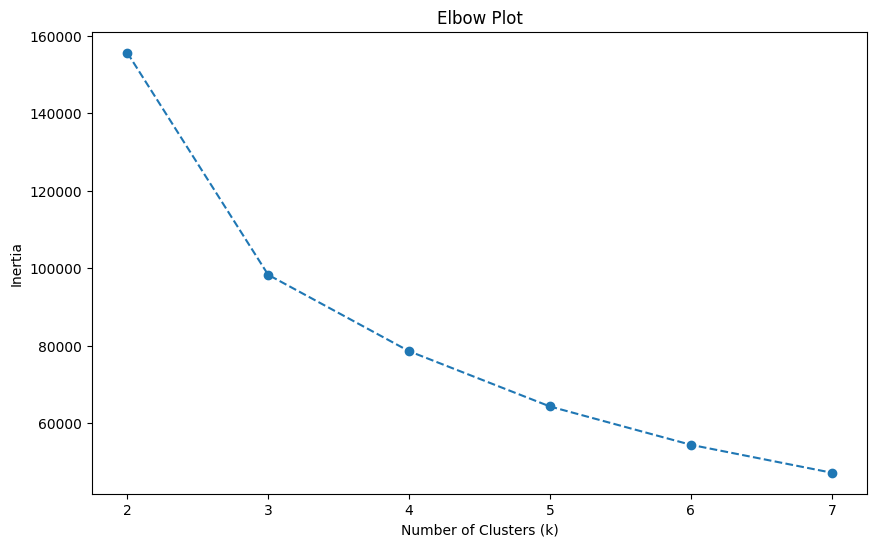

In [22]:
silhouette_and_elbow(statcast_scale_bbes(statcast_hit_in_play(df[cols])),range(2,8))

In [26]:
bbes = statcast_hit_in_play(df[cols]).dropna()
scaled_bbes = statcast_scale_bbes(bbes)
km = KMeans(n_clusters=3, n_init=10, random_state=RANDOM_STATE).fit(scaled_bbes)
bbes['cluster'] = km.fit_predict(scaled_bbes)


In [27]:
print(bbes[desc_cols].groupby('cluster').mean())
print(bbes[desc_cols].groupby('cluster').std())

         launch_speed  launch_angle
cluster                            
0            68.94333    -21.529754
1           98.259312       8.30055
2           82.499283     44.064338
         launch_speed  launch_angle
cluster                            
0           13.737808      23.48109
1            6.763297     16.029583
2           10.373859     17.306528


### Initial clustering
- 3 main clusters
    - Ground balls (69 EV, -21 LA)
    - Line drives (98 EV, 8 LA)
    - Fly balls (82 EV, 44 LA)

- Should recluster line drives, looking for line drives that are likely to get over the infield (in terms of EV and LA)


In [31]:
line_drives = bbes[(bbes['cluster']==1)].drop('cluster',axis=1,inplace=False)
line_drives_scaled = statcast_scale_bbes(line_drives[scaling_cols])
line_drives.head()

,name,launch_speed,launch_angle,batter,events,hc_x,hc_y,relative_spray,description
1254,David Peralta,98.1,-17,444482,field_out,156.22,161.23,-39.744657,hit_into_play
1309,Jake Cronenworth,102.1,8,630105,field_out,99.52,154.14,30.408772,hit_into_play
24,Eugenio Suárez,102.5,15,553993,single,87.83,104.64,-21.874172,hit_into_play
61,Randal Grichuk,102.7,31,545341,home_run,183.54,51.3,21.576560,hit_into_play
198,Lourdes Gurriel,104.2,15,666971,single,58.97,118.16,-39.675179,hit_into_play


{'2': 0.3766834317584174, '3': 0.36612032655345134, '4': 0.3512564592164771, '5': 0.3429088682286378}


{'2': 0.3766834317584174,
 '3': 0.36612032655345134,
 '4': 0.3512564592164771,
 '5': 0.3429088682286378}

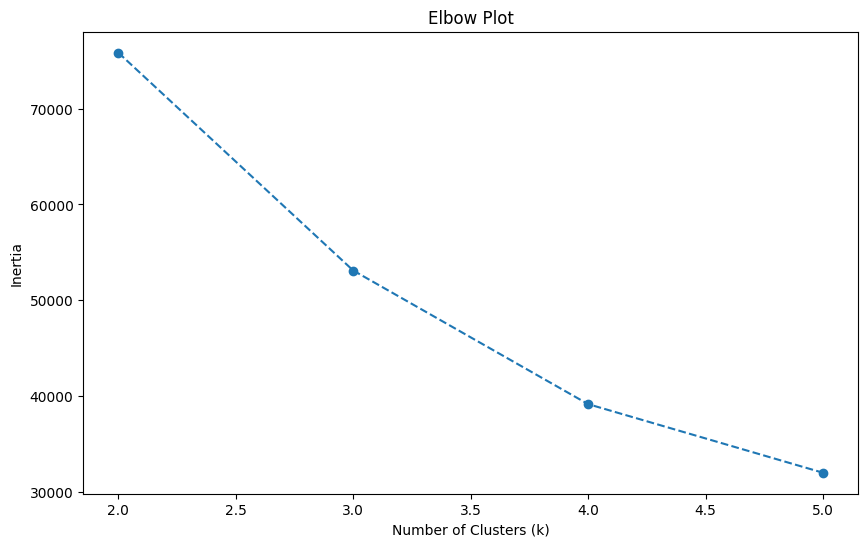

In [32]:
k_range = range(2,6)
silhouette_and_elbow(line_drives_scaled, k_range)


<Axes: xlabel='hc_x', ylabel='hc_y'>

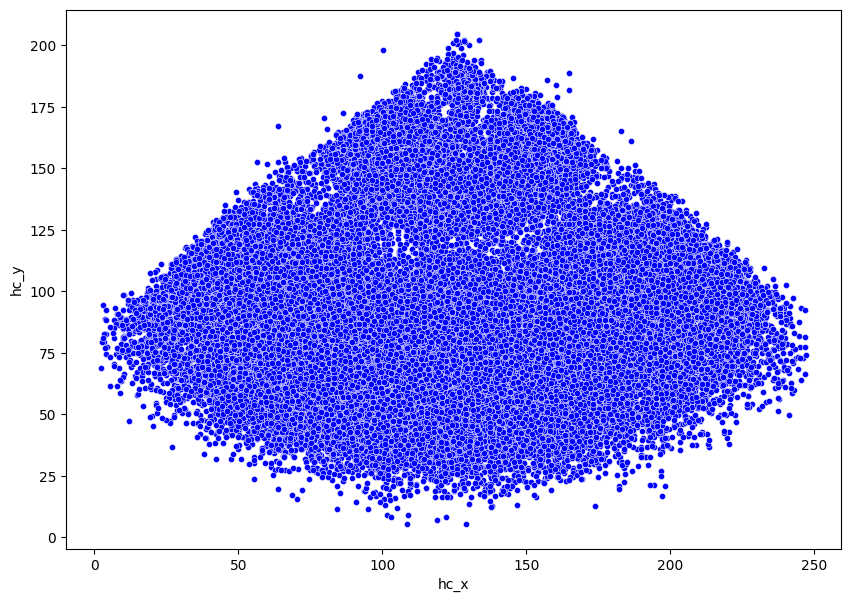

In [34]:
plt.figure(figsize=(10,7))

sns.scatterplot(data = line_drives,
                x = 'hc_x',
                y = 'hc_y',
                color = 'blue',
                s=20
               )

In [41]:
stinger_counts = get_counts(stingers)
stinger_stats = create_stats(counts)

In [42]:
print(stinger_counts)
print(stinger_stats)

{'singles': 7922, 'doubles': 2799, 'triples': 201, 'home runs': 167, 'field outs': 3646, 'gidps': 71, 'force_outs': 65, 'dps': 91, 'fcs': 10, 'k': 0, 'bb': 0, 'ibb': 0, 'hbp': 0, 'e': 0}
{'BA': 0.7406492118621427, 'SLG': 0.9879107667646273}


### Conclusion
- Stingers are a valuable type of batted ball, and captures a type of elite contact that isn't captured by barrel rates or traditional hard-hit metrics which result in a batting average over 0.700 and slug near 1.000. It is also found to be a better predictor of avethan hard-hit rate and sweet-spot rate